In [1]:
# imports
import pandas as pd
import numpy as np
import glob
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.svm import SVR
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt

In [2]:
# functions
def check_for_nans(df, file_name):
    nan_rows = df[df.isna().any(axis=1)]
    if not nan_rows.empty:
        print(f"NaN values found in file: {file_name}")
        for index, row in nan_rows.iterrows():
            print(f"Line {index + 1}: {row[row.isna()].index.tolist()}")

In [3]:
import glob
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

# tsv_files = glob.glob('data/*.tsv')
tsv_files = glob.glob("data/newdata/*.tsv")

# Opportunity to filter the files (based on folder for example)
filtered_files = tsv_files

# Window sizes
n_past = 5
m_future = 1

# List to store all sliding window features and labels
all_features = []
all_labels = []

# Iterate through each TSV file
for file in tsv_files:
    df = pd.read_csv(file, delimiter="\t")
    df = df.drop(
        columns=[
            "SequenceID",
            "TimeStamp",
            "First30SecondsCoinsCollected",
            "First30SecondsAsteroidHits",
        ]
    )
    
    check_for_nans(df, file)
    # Create sliding window
    features = []
    labels = []

    # Iterate through the data to create windows
    for i in range(n_past, len(df) - m_future):
        window_features = []

        # Add past entries (t-n to t-1)
        for j in range(n_past):
            window_features.extend(df.iloc[i - n_past + j].drop("Score").values)
        # Add future entries (t+1 to t+m)
        for j in range(1, m_future + 1):
            window_features.extend(df.iloc[i + j].drop("Score").values)

        # Append the current feature vector and label
        features.append(window_features)
        labels.append(df.iloc[i]["Score"])

    all_features.append(np.array(features))
    all_labels.append(np.array(labels))

# Concatenate all features and labels
X_all = np.concatenate(all_features)
y_all = np.concatenate(all_labels)

# Define the column names based on the original DataFrame
original_columns = df.drop(columns=["Score"]).columns
num_features = X_all.shape[1]
column_names = [f'{col}_t-{n_past-j}' for j in range(n_past) for col in original_columns] + \
               [f'{col}_t+{j}' for j in range(1, m_future + 1) for col in original_columns]

# Print shapes to verify
print(f"Shape of X_all: {X_all.shape}")
print(f"Shape of y_all: {y_all.shape}")

# Print sample entries with adjusted headers
print("Sample feature entry 1 (with headers):")
print(pd.DataFrame([X_all[0]], columns=column_names))
print("Sample feature entry 2 (with headers):")
print(pd.DataFrame([X_all[1]], columns=column_names))
print("Sample label entry 1:", y_all[0])
print("Sample label entry 2:", y_all[1])

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X_all, y_all, test_size=0.2, random_state=42
)

# Print shapes of the training and testing sets
print(f"Shape of X_train: {X_train.shape}")
print(f"Shape of X_test: {X_test.shape}")
print(f"Shape of y_train: {y_train.shape}")
print(f"Shape of y_test: {y_test.shape}")

# Disable scientific notation for better readability
np.set_printoptions(suppress=True)

# Train a linear regression model
model = LinearRegression()
k = 3
kf = KFold(n_splits=k, shuffle=True, random_state=42)

# Perform k-fold cross-validation
cv_scores = cross_val_score(model, X_all, y_all, cv=kf, scoring='r2')

# Calculate mean and standard deviation of the cross-validation scores
mean_cv_score = np.mean(cv_scores)
std_cv_score = np.std(cv_scores)

print(f"Cross-Validation R^2 Scores: {cv_scores}")
print(f"Mean R^2 Score: {mean_cv_score}")
print(f"Standard Deviation of R^2 Scores: {std_cv_score}")

Shape of X_all: (1572, 204)
Shape of y_all: (1572,)
Sample feature entry 1 (with headers):
   RelativeTime_t-5  CollectableCoin1Distance_t-5  \
0               0.0                          -1.0   

   CollectableCoin2Distance_t-5  CollectableCoin3Distance_t-5  \
0                          -1.0                          -1.0   

   CollectableCoin4Distance_t-5  CollectableCoin5Distance_t-5  \
0                          -1.0                          -1.0   

   TimeStepCoinsCollected_t-5  TimeStepCoinNearMiss_t-5  \
0                         0.0                       0.0   

   Asteroid1Distance_t-5  Asteroid2Distance_t-5  ...  \
0                   -1.0                   -1.0  ...   

   VeryRecentScoreDifference_t+1  RecentScoreDifference_t+1  \
0                           32.1                       32.1   

   LongTermScoreDifference_t+1  VeryRecentMultiplierDifference_t+1  \
0                         32.1                                 0.3   

   RecentMultiplierDifference_t+1  LongT

Model R^2 score: 0.31781896587895553
Mean Squared Error (MSE): 453.9835615387641
Mean Absolute Error (MAE): 14.576573325536925
R^2 Score: 0.31781896587895553


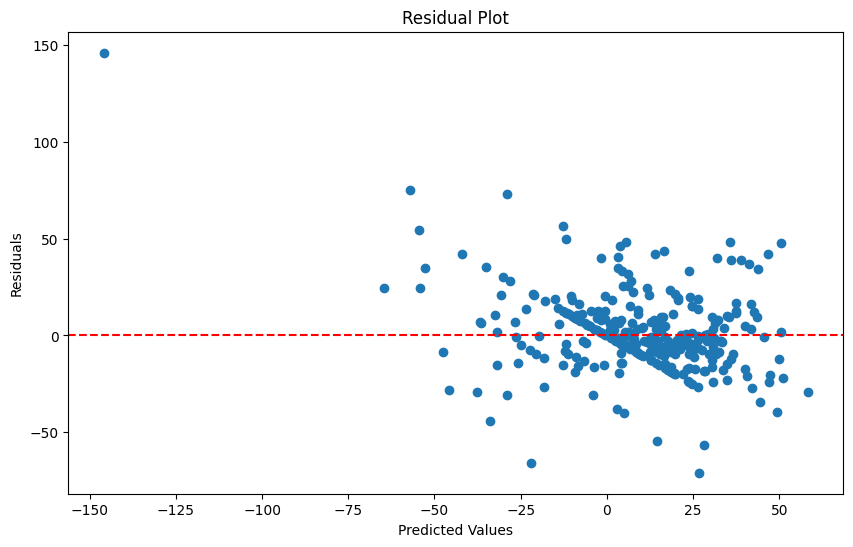

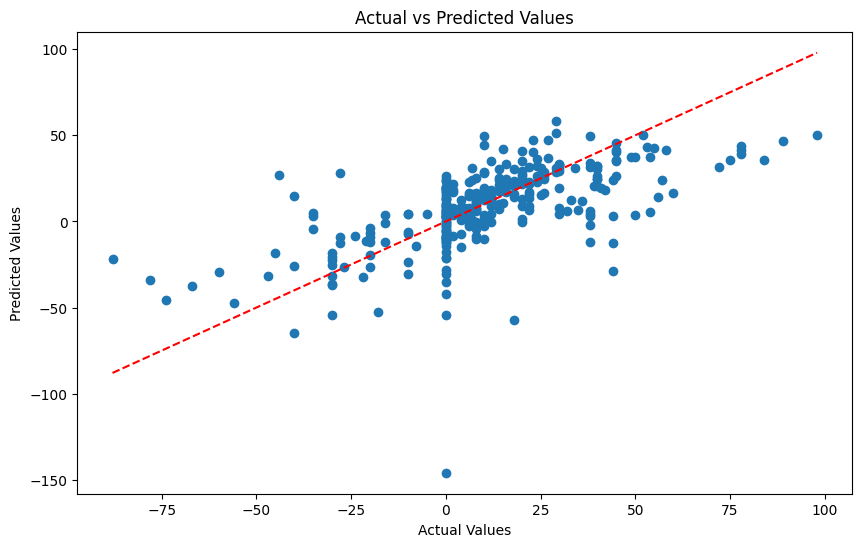

In [4]:
#Tests
# Evaluate the model
model.fit(X_train, y_train)  # Fit the model

score = model.score(X_test, y_test)
print(f"Model R^2 score: {score}")

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Predict on the test set
y_pred = model.predict(X_test)

# Calculate performance metrics
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error (MSE): {mse}")
print(f"Mean Absolute Error (MAE): {mae}")
print(f"R^2 Score: {r2}")

import matplotlib.pyplot as plt

# Calculate residuals
residuals = y_test - y_pred

# Plot residuals
plt.figure(figsize=(10, 6))
plt.scatter(y_pred, residuals)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.show()

# Plot actual vs predicted values
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs Predicted Values')
plt.show()

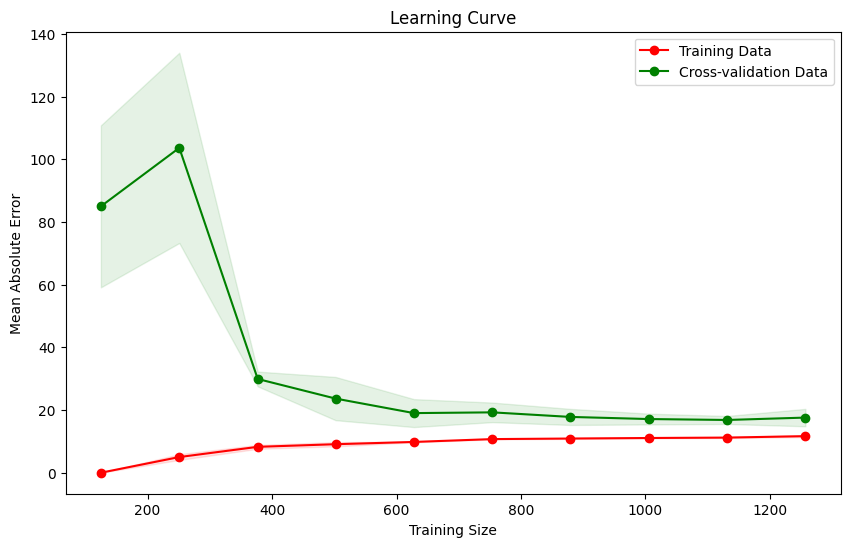

In [12]:
# Generate learning curve data
train_sizes, train_scores, test_scores = learning_curve(
    model, X_all, y_all, cv=5, scoring='neg_mean_absolute_error', n_jobs=-1,
    train_sizes=np.linspace(0.1, 1.0, 10)
)

# Convert negative MAE to positive MAE
train_scores_mean = -np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = -np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

# Plot learning curve
plt.figure(figsize=(10, 6))
plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.1, color='r')
plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.1, color='g')
plt.plot(train_sizes, train_scores_mean, 'o-', color='r', label='Training Data')
plt.plot(train_sizes, test_scores_mean, 'o-', color='g', label='Cross-validation Data')
plt.xlabel('Training Size')
plt.ylabel('Mean Absolute Error')
plt.title('Learning Curve')
plt.legend(loc='best')
plt.show()

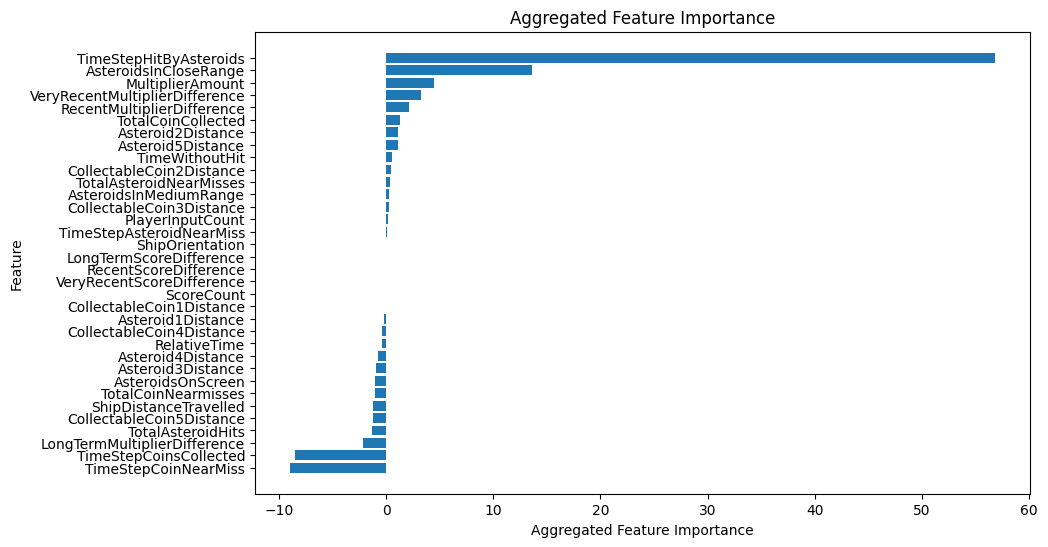

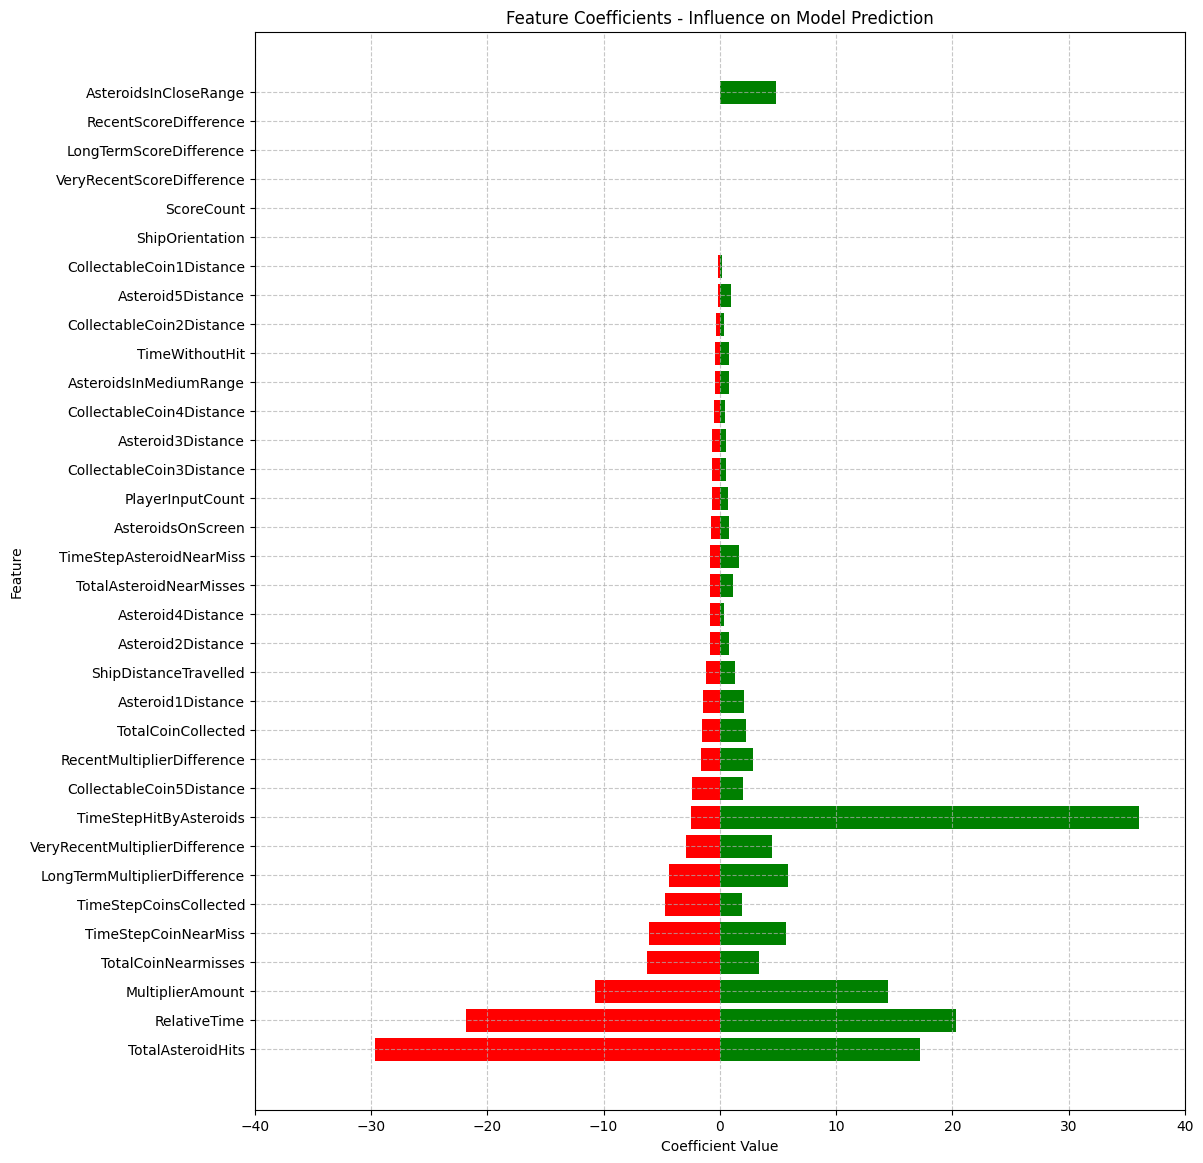

In [33]:
# Get feature importances
feature_importances = model.coef_

# Extract base feature names
base_feature_names = [col.split('_')[0] for col in column_names]

# Aggregate feature importances by base feature names
aggregated_importances = {}
for base_feature in set(base_feature_names):
    aggregated_importances[base_feature] = np.sum([importance for feature, importance in zip(base_feature_names, feature_importances) if feature == base_feature])

# Convert to DataFrame for easier plotting
aggregated_importances_df = pd.DataFrame(list(aggregated_importances.items()), columns=['Feature', 'Importance'])
aggregated_importances_df = aggregated_importances_df.sort_values(by='Importance', ascending=False)

# Plot aggregated feature importances
plt.figure(figsize=(10, 6))
plt.barh(aggregated_importances_df['Feature'], aggregated_importances_df['Importance'])
plt.xlabel('Aggregated Feature Importance')
plt.ylabel('Feature')
plt.title('Aggregated Feature Importance')
plt.gca().invert_yaxis()  # Invert y-axis to have the most important feature at the top
plt.show()


import matplotlib.pyplot as plt

# Assuming 'model' is your trained model and 'X_train' is your training data
feature_names = base_feature_names
coefficients = model.coef_  # Assuming a single-output model
sorted_indices = np.argsort(coefficients)
feature_names_sorted = [feature_names[i] for i in sorted_indices]
coefficients_sorted = coefficients[sorted_indices]

# Plot the coefficients
plt.figure(figsize=(12, 14))  
plt.xlim(-40, 40)
colors = ['green' if coef > 0 else 'red' for coef in coefficients_sorted]
plt.barh(feature_names_sorted, coefficients_sorted, color=colors)
plt.xlabel('Coefficient Value')
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.ylabel('Feature')
plt.title('Feature Coefficients - Influence on Model Prediction')
plt.show()
